In [ ]:
import moxing as mox
mox.file.copy_parallel(src_url="obs://ascend-professional-construction-dataset/ComputerVision/Unet",dst_url="./")

In [2]:
import os
import argparse
import ast
import numpy as np
import cv2
import mindspore
import mindspore.nn as nn
import mindspore.ops.operations as F
from mindspore import Model, context
from mindspore.nn.loss.loss import _Loss
from mindspore.communication.management import init, get_group_size
from mindspore.train.callback import CheckpointConfig, ModelCheckpoint
from mindspore.context import ParallelMode
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.common.initializer import TruncatedNormal
from mindspore.nn import CentralCrop
from PIL import Image, ImageSequence
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as c_vision
from mindspore.dataset.vision.utils import Inter
from mindspore.communication.management import get_rank, get_group_size
from collections import deque
import time
from mindspore.train.callback import Callback
from mindspore.common.tensor import Tensor
from scipy.special import softmax
from matplotlib import pyplot as plt
device_id = 2
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend", save_graphs=False)

mindspore.set_seed(1)


[WARNING] ME(1054:281473647606064,MainProcess):2021-03-15-01:02:35.820.593 [mindspore/_check_version.py:207] MindSpore version 1.1.1 and "te" wheel package version 1.0 does not match, reference to the match info on: https://www.mindspore.cn/install
MindSpore version 1.1.1 and "topi" wheel package version 0.6.0 does not match, reference to the match info on: https://www.mindspore.cn/install
[WARNING] ME(1054:281473647606064,MainProcess):2021-03-15-01:02:36.840.615 [mindspore/ops/operations/array_ops.py:2302] WARN_DEPRECATED: The usage of Pack is deprecated. Please use Stack.


INFO:matplotlib.font_manager:generated new fontManager


(30, 512, 512)
(30, 512, 512)


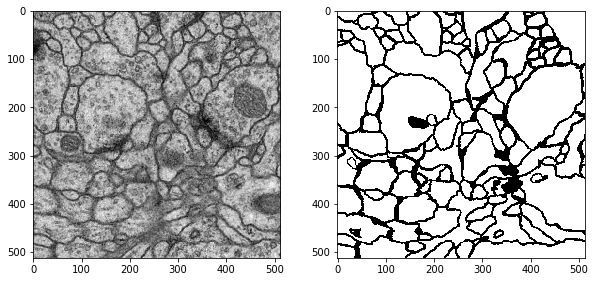

In [3]:
#打印图像和标签的形状，并展示第一张图像和标签
image= np.array([np.array(p) for p in ImageSequence.Iterator(Image.open("./data/train-volume.tif"))])

label= np.array([np.array(p) for p in ImageSequence.Iterator(Image.open("./data/train-labels.tif"))])

print(image.shape)
print(label.shape)
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(image[0],cmap='gray')
plt.subplot(2,2,2)
plt.imshow(label[0],cmap='gray')
plt.show()


([], <a list of 0 Text yticklabel objects>)

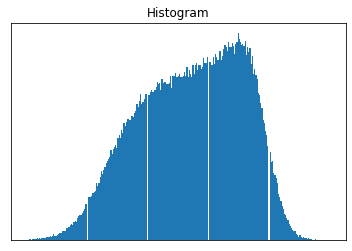

In [4]:
plt.hist(image[0].ravel(), 256)
plt.title("Histogram")
plt.xticks([])
plt.yticks([])


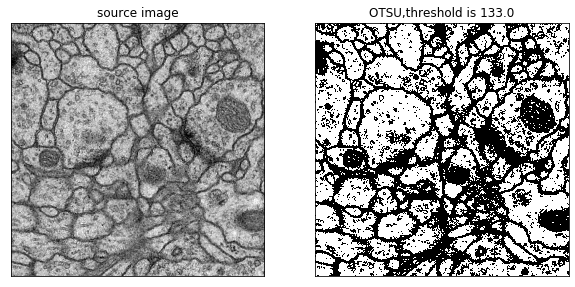

In [5]:
# 二值化处理，thesh=0代表其从0开始扫描
ret1, th1 = cv2.threshold(src=image[0], thresh=0, 
                          maxval=255, type=cv2.THRESH_OTSU)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(image[0],cmap='gray')
plt.title("source image")
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(th1, "gray")
plt.title("OTSU,threshold is " + str(ret1))
plt.xticks([])
plt.yticks([])
plt.show()


In [6]:
cfg_unet = {
    'name': 'Unet',
    'lr': 0.0001,
    'epochs': 400,
    'distribute_epochs': 1600,
    'batchsize': 16,
    'cross_valid_ind': 1,
    'num_classes': 2,
    'num_channels': 1,
    'keep_checkpoint_max': 10,
    'weight_decay': 0.0005,
    'loss_scale': 1024.0,
    'FixedLossScaleManager': 1024.0,
    'resume': False,
    'resume_ckpt': './',
}


In [7]:
class DoubleConv(nn.Cell):

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        init_value_0 = TruncatedNormal(0.06)
        init_value_1 = TruncatedNormal(0.06)
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.SequentialCell(
            [nn.Conv2d(in_channels, mid_channels, kernel_size=3, has_bias=True,
                       weight_init=init_value_0, pad_mode="valid"),
             nn.ReLU(),
             nn.Conv2d(mid_channels, out_channels, kernel_size=3, has_bias=True,
                       weight_init=init_value_1, pad_mode="valid"),
             nn.ReLU()]
        )

    def construct(self, x):
        return self.double_conv(x)


class Down(nn.Cell):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.maxpool_conv = nn.SequentialCell(
            [nn.MaxPool2d(kernel_size=2, stride=2),
             DoubleConv(in_channels, out_channels)]
        )

    def construct(self, x):
        return self.maxpool_conv(x)


class Up1(nn.Cell):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        self.concat = F.Concat(axis=1)
        self.factor = 56.0 / 64.0
        self.center_crop = CentralCrop(central_fraction=self.factor)
        self.print_fn = F.Print()
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        self.up = nn.Conv2dTranspose(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def construct(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.relu(x1)
        x2 = self.center_crop(x2)
        x = self.concat((x1, x2))
        return self.conv(x)


class Up2(nn.Cell):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        self.concat = F.Concat(axis=1)
        self.factor = 104.0 / 136.0
        self.center_crop = CentralCrop(central_fraction=self.factor)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        self.up = nn.Conv2dTranspose(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def construct(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.relu(x1)
        x2 = self.center_crop(x2)
        x = self.concat((x1, x2))
        return self.conv(x)


class Up3(nn.Cell):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        self.concat = F.Concat(axis=1)
        self.factor = 200 / 280
        self.center_crop = CentralCrop(central_fraction=self.factor)
        self.print_fn = F.Print()
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        self.up = nn.Conv2dTranspose(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def construct(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.relu(x1)
        x2 = self.center_crop(x2)
        x = self.concat((x1, x2))
        return self.conv(x)


class Up4(nn.Cell):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        self.concat = F.Concat(axis=1)
        self.factor = 392 / 568
        self.center_crop = CentralCrop(central_fraction=self.factor)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        self.up = nn.Conv2dTranspose(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def construct(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.relu(x1)
        x2 = self.center_crop(x2)
        x = self.concat((x1, x2))
        return self.conv(x)


class OutConv(nn.Cell):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        init_value = TruncatedNormal(0.06)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, has_bias=True, weight_init=init_value)

    def construct(self, x):
        x = self.conv(x)
        return x


In [8]:
class UNet(nn.Cell):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up1(1024, 512)
        self.up2 = Up2(512, 256)
        self.up3 = Up3(256, 128)
        self.up4 = Up4(128, 64)
        self.outc = OutConv(64, n_classes)

    def construct(self, x):

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [9]:
class CrossEntropyWithLogits(_Loss):
    #重写损失函数。
    def __init__(self):
        super(CrossEntropyWithLogits, self).__init__()
        self.transpose_fn = F.Transpose()
        self.reshape_fn = F.Reshape()
        self.softmax_cross_entropy_loss = nn.SoftmaxCrossEntropyWithLogits()
        self.cast = F.Cast()

    def construct(self, logits, label):
        # NCHW->NHWC
        logits = self.transpose_fn(logits, (0, 2, 3, 1))
        logits = self.cast(logits, mindspore.float32)
        label = self.transpose_fn(label, (0, 2, 3, 1))

        loss = self.reduce_mean(self.softmax_cross_entropy_loss(self.reshape_fn(logits, (-1, 2)),
                                                                self.reshape_fn(label, (-1, 2))))
        return self.get_loss(loss)


In [10]:
def _load_multipage_tiff(path):
    """Load tiff images containing many images in the channel dimension"""
    return np.array([np.array(p) for p in ImageSequence.Iterator(Image.open(path))])

def _get_val_train_indices(length, fold, ratio=0.8):
    assert 0 < ratio <= 1, "Train/total data ratio must be in range (0.0, 1.0]"
    np.random.seed(0)
    indices = np.arange(0, length, 1, dtype=np.int)
    np.random.shuffle(indices)

    if fold is not None:
        indices = deque(indices)
        indices.rotate(fold * round((1.0 - ratio) * length))
        indices = np.array(indices)
        train_indices = indices[:round(ratio * len(indices))]
        val_indices = indices[round(ratio * len(indices)):]
    else:
        train_indices = indices
        val_indices = []
    return train_indices, val_indices

def data_post_process(img, mask):

    img = np.expand_dims(img, axis=0)
    mask = (mask > 0.5).astype(np.int)
    mask = (np.arange(mask.max() + 1) == mask[..., None]).astype(int)
    mask = mask.transpose(2, 0, 1).astype(np.float32)
    return img, mask


def train_data_augmentation(img, mask):

    h_flip = np.random.random()
    if h_flip > 0.5:
        img = np.flipud(img)
        mask = np.flipud(mask)
    v_flip = np.random.random()
    if v_flip > 0.5:
        img = np.fliplr(img)
        mask = np.fliplr(mask)

    left = int(np.random.uniform()*0.3*572)
    right = int((1-np.random.uniform()*0.3)*572)
    top = int(np.random.uniform()*0.3*572)
    bottom = int((1-np.random.uniform()*0.3)*572)


    img = img[top:bottom, left:right]
    mask = mask[top:bottom, left:right]

    #adjust brightness
    brightness = np.random.uniform(-0.2, 0.2)
    img = np.float32(img+brightness*np.ones(img.shape))
    img = np.clip(img, -1.0, 1.0)

    return img, mask


def create_dataset(data_dir, repeat=400, train_batch_size=16, augment=False, cross_val_ind=1, run_distribute=False):

    images = _load_multipage_tiff(os.path.join(data_dir, 'train-volume.tif'))
    masks = _load_multipage_tiff(os.path.join(data_dir, 'train-labels.tif'))

    train_indices, val_indices = _get_val_train_indices(len(images), cross_val_ind)
    train_images = images[train_indices]
    train_masks = masks[train_indices]
    train_images = np.repeat(train_images, repeat, axis=0)
    train_masks = np.repeat(train_masks, repeat, axis=0)
    val_images = images[val_indices]
    val_masks = masks[val_indices]

    train_image_data = {"image": train_images}
    train_mask_data = {"mask": train_masks}
    valid_image_data = {"image": val_images}
    valid_mask_data = {"mask": val_masks}


    ds_train_images = ds.NumpySlicesDataset(data=train_image_data, sampler=None, shuffle=False)
    ds_train_masks = ds.NumpySlicesDataset(data=train_mask_data, sampler=None, shuffle=False)

    if run_distribute:
        rank_id = get_rank()
        rank_size = get_group_size()
        ds_train_images = ds.NumpySlicesDataset(data=train_image_data,
                                                sampler=None,
                                                shuffle=False,
                                                num_shards=rank_size,
                                                shard_id=rank_id)
        ds_train_masks = ds.NumpySlicesDataset(data=train_mask_data,
                                               sampler=None,
                                               shuffle=False,
                                               num_shards=rank_size,
                                               shard_id=rank_id)

    ds_valid_images = ds.NumpySlicesDataset(data=valid_image_data, sampler=None, shuffle=False)
    ds_valid_masks = ds.NumpySlicesDataset(data=valid_mask_data, sampler=None, shuffle=False)

    c_resize_op = c_vision.Resize(size=(388, 388), interpolation=Inter.BILINEAR)
    c_pad = c_vision.Pad(padding=92)
    c_rescale_image = c_vision.Rescale(1.0/127.5, -1)
    c_rescale_mask = c_vision.Rescale(1.0/255.0, 0)

    c_trans_normalize_img = [c_rescale_image, c_resize_op, c_pad]
    c_trans_normalize_mask = [c_rescale_mask, c_resize_op, c_pad]
    c_center_crop = c_vision.CenterCrop(size=388)

    train_image_ds = ds_train_images.map(input_columns="image", operations=c_trans_normalize_img)
    train_mask_ds = ds_train_masks.map(input_columns="mask", operations=c_trans_normalize_mask)
    train_ds = ds.zip((train_image_ds, train_mask_ds))
    train_ds = train_ds.project(columns=["image", "mask"])
    if augment:
        augment_process = train_data_augmentation
        c_resize_op = c_vision.Resize(size=(572, 572), interpolation=Inter.BILINEAR)
        train_ds = train_ds.map(input_columns=["image", "mask"], operations=augment_process)
        train_ds = train_ds.map(input_columns="image", operations=c_resize_op)
        train_ds = train_ds.map(input_columns="mask", operations=c_resize_op)

    train_ds = train_ds.map(input_columns="mask", operations=c_center_crop)
    post_process = data_post_process
    train_ds = train_ds.map(input_columns=["image", "mask"], operations=post_process)
    train_ds = train_ds.shuffle(repeat*24)
    train_ds = train_ds.batch(batch_size=train_batch_size, drop_remainder=True)

    valid_image_ds = ds_valid_images.map(input_columns="image", operations=c_trans_normalize_img)
    valid_mask_ds = ds_valid_masks.map(input_columns="mask", operations=c_trans_normalize_mask)
    valid_ds = ds.zip((valid_image_ds, valid_mask_ds))
    valid_ds = valid_ds.project(columns=["image", "mask"])
    valid_ds = valid_ds.map(input_columns="mask", operations=c_center_crop)
    post_process = data_post_process
    valid_ds = valid_ds.map(input_columns=["image", "mask"], operations=post_process)
    valid_ds = valid_ds.batch(batch_size=1, drop_remainder=True)

    return train_ds, valid_ds


In [11]:
class StepLossTimeMonitor(Callback):

    def __init__(self, batch_size, per_print_times=1):
        super(StepLossTimeMonitor, self).__init__()
        if not isinstance(per_print_times, int) or per_print_times < 0:
            raise ValueError("print_step must be int and >= 0.")
        self._per_print_times = per_print_times
        self.batch_size = batch_size

    def step_begin(self, run_context):
        self.step_time = time.time()

    def step_end(self, run_context):

        step_seconds = time.time() - self.step_time
        step_fps = self.batch_size*1.0/step_seconds

        cb_params = run_context.original_args()
        loss = cb_params.net_outputs

        if isinstance(loss, (tuple, list)):
            if isinstance(loss[0], Tensor) and isinstance(loss[0].asnumpy(), np.ndarray):
                loss = loss[0]

        if isinstance(loss, Tensor) and isinstance(loss.asnumpy(), np.ndarray):
            loss = np.mean(loss.asnumpy())

        cur_step_in_epoch = (cb_params.cur_step_num - 1) % cb_params.batch_num + 1

        if isinstance(loss, float) and (np.isnan(loss) or np.isinf(loss)):
            raise ValueError("epoch: {} step: {}. Invalid loss, terminating training.".format(
                cb_params.cur_epoch_num, cur_step_in_epoch))
        if self._per_print_times != 0 and cb_params.cur_step_num % self._per_print_times == 0:
            # TEST
            print("step: %s, loss is %s, fps is %s" % (cur_step_in_epoch, loss, step_fps), flush=True)


In [12]:
def train_net(data_dir, cross_valid_ind=1, epochs=400, batch_size=16, lr=0.0001, run_distribute=False, cfg=None):
    if run_distribute:
        init()
        group_size = get_group_size()
        parallel_mode = ParallelMode.DATA_PARALLEL
        context.set_auto_parallel_context(parallel_mode=parallel_mode,
                                          device_num=group_size,
                                          gradients_mean=False)
    net = UNet(n_channels=cfg['num_channels'], n_classes=cfg['num_classes'])

    if cfg['resume']:
        param_dict = load_checkpoint(cfg['resume_ckpt'])
        load_param_into_net(net, param_dict)

    criterion = CrossEntropyWithLogits()
    train_dataset, _ = create_dataset(data_dir, epochs, batch_size, True, cross_valid_ind, run_distribute)
    train_data_size = train_dataset.get_dataset_size()
    print("dataset length is:", train_data_size)
    ckpt_config = CheckpointConfig(save_checkpoint_steps=train_data_size,
                                   keep_checkpoint_max=cfg['keep_checkpoint_max'])
    ckpoint_cb = ModelCheckpoint(prefix='ckpt_unet_medical_adam',
                                 directory='./ckpt_{}/'.format(device_id),
                                 config=ckpt_config)

    optimizer = nn.Adam(params=net.trainable_params(), learning_rate=lr, weight_decay=cfg['weight_decay'],
                        loss_scale=cfg['loss_scale'])

    loss_scale_manager = mindspore.train.loss_scale_manager.FixedLossScaleManager(cfg['FixedLossScaleManager'], False)

    model = Model(net, loss_fn=criterion, loss_scale_manager=loss_scale_manager, optimizer=optimizer, amp_level="O3")

    print("============== Starting Training ==============")
    model.train(2, train_dataset, callbacks=[StepLossTimeMonitor(batch_size=batch_size), ckpoint_cb],
                dataset_sink_mode=False)
    print("============== End Training ==============")


In [13]:
data_url = './data'

run_distribute = False
epoch_size = cfg_unet['epochs'] if not run_distribute else cfg_unet['distribute_epochs']

train_net(data_dir=data_url, cross_valid_ind=cfg_unet['cross_valid_ind'], epochs=epoch_size,
          batch_size=cfg_unet['batchsize'], lr=cfg_unet['lr'], run_distribute=run_distribute,
          cfg=cfg_unet)


dataset length is: 600
============== Starting Training ==============
step: 1, loss is 0.7011225, fps is 0.1296080562471482
step: 2, loss is 0.68978643, fps is 64.62294842017279
step: 3, loss is 0.681577, fps is 64.95458038688845
step: 4, loss is 0.6631299, fps is 65.10183939334264
step: 5, loss is 0.6250401, fps is 65.19031308588248
step: 6, loss is 0.55235034, fps is 65.14652050922123
step: 7, loss is 0.601074, fps is 65.09950274817484
step: 8, loss is 0.56049174, fps is 65.09160991706038
step: 9, loss is 0.5424385, fps is 65.07538826741967
step: 10, loss is 0.54935193, fps is 64.91330140652704
step: 11, loss is 0.5673812, fps is 65.15252901137544
step: 12, loss is 0.5615636, fps is 65.17891628869184
step: 13, loss is 0.54873556, fps is 65.26893278479659
step: 14, loss is 0.53070337, fps is 65.06851070967667
step: 15, loss is 0.5538797, fps is 65.11731600723473
step: 16, loss is 0.5458672, fps is 65.20906315406934
step: 17, loss is 0.52458906, fps is 65.17543472877101
step: 18, loss

In [14]:
class dice_coeff(nn.Metric):
    def __init__(self):
        super(dice_coeff, self).__init__()
        self.clear()

    def clear(self):
        self._dice_coeff_sum = 0
        self._samples_num = 0

    def update(self, *inputs):
        if len(inputs) != 2:
            raise ValueError('Mean dice coeffcient need 2 inputs (y_pred, y), but got {}'.format(len(inputs)))

        y_pred = self._convert_data(inputs[0])
        y = self._convert_data(inputs[1])
        self._samples_num += y.shape[0]
        y_pred = y_pred.transpose(0, 2, 3, 1)
        y = y.transpose(0, 2, 3, 1)
        y_pred = softmax(y_pred, axis=3)

        inter = np.dot(y_pred.flatten(), y.flatten())
        union = np.dot(y_pred.flatten(), y_pred.flatten()) + np.dot(y.flatten(), y.flatten())

        single_dice_coeff = 2 * float(inter) / float(union + 1e-6)
        print("single dice coeff is:", single_dice_coeff)
        self._dice_coeff_sum += single_dice_coeff

    def eval(self):
        if self._samples_num == 0:
            raise RuntimeError('Total samples num must not be 0.')
        return self._dice_coeff_sum / float(self._samples_num)


In [15]:
def test_net(data_dir, ckpt_path, cross_valid_ind=1, cfg=None):
    net = UNet(n_channels=cfg['num_channels'], n_classes=cfg['num_classes'])
    param_dict = load_checkpoint(ckpt_path)
    load_param_into_net(net, param_dict)

    criterion = CrossEntropyWithLogits()
    _, valid_dataset = create_dataset(data_dir, 1, 1, False, cross_valid_ind, False)
    model = Model(net, loss_fn=criterion, metrics={"dice_coeff": dice_coeff()})

    print("============== Starting Evaluating ============")
    dice_score = model.eval(valid_dataset, dataset_sink_mode=False)
    print("Cross valid dice coeff is:", dice_score)


In [16]:
ckpt_path = './ckpt_2/ckpt_unet_medical_adam-2_600.ckpt'
test_net(data_dir=data_url, ckpt_path=ckpt_path, cross_valid_ind=cfg_unet['cross_valid_ind'],
         cfg=cfg_unet)


============== Starting Evaluating ============
single dice coeff is: 0.9053852793871535
single dice coeff is: 0.9105223777160442
single dice coeff is: 0.9271962117878177
single dice coeff is: 0.928957563919879
single dice coeff is: 0.9209360657011245
single dice coeff is: 0.9092419754966059
Cross valid dice coeff is: {'dice_coeff': 0.9170399123347709}


============== Starting Evaluating ============
single dice coeff is: 0.9053852793871535
single dice coeff is: 0.9105223777160442
single dice coeff is: 0.9271962117878177
single dice coeff is: 0.928957563919879
single dice coeff is: 0.9209360657011245
single dice coeff is: 0.9092419754966059
Cross valid dice coeff is: {'dice_coeff': 0.9170399123347709}


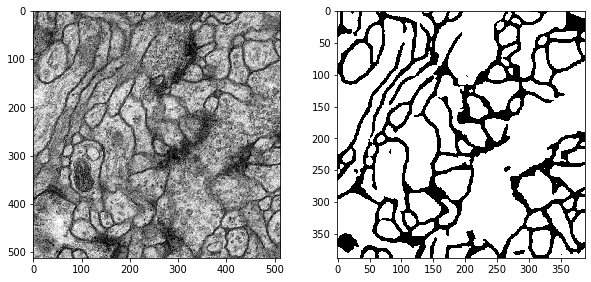

In [17]:
def test_net(data_dir, ckpt_path, cross_valid_ind=1, cfg=None):
    net = UNet(n_channels=cfg['num_channels'], n_classes=cfg['num_classes'])
    param_dict = load_checkpoint(ckpt_path)
    load_param_into_net(net, param_dict)

    criterion = CrossEntropyWithLogits()
    _, valid_dataset = create_dataset(data_dir, 1, 1, False, cross_valid_ind, False)
    model = Model(net, loss_fn=criterion, metrics={"dice_coeff": dice_coeff()})

    print("============== Starting Evaluating ============")
    dice_score = model.eval(valid_dataset, dataset_sink_mode=False)
    print("Cross valid dice coeff is:", dice_score)
    testimage=np.array([np.array(p) for p in ImageSequence.Iterator(Image.open("./data/test-volume.tif"))])
    testdata=testimage[10]
    image = Image.fromarray(testdata)
    image = image.resize((388, 388))
    testdata = np.asarray(image)
    testdata = np.pad(testdata, ((92, 92),(92, 92) ),  'symmetric')
    testdata = testdata/127.5-1
    testdata = testdata.astype(np.float32)
    testdata = testdata.reshape(1,1,572,572)
    output = model.predict(Tensor(testdata))
    pred = np.argmax(output.asnumpy(), axis=1)
    pred = pred.reshape(388, 388)
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.imshow(testimage[10],cmap='gray')
    plt.subplot(2,2,2)
    plt.imshow(pred,cmap='gray')
    plt.show()


ckpt_path = './ckpt_2/ckpt_unet_medical_adam-2_600.ckpt'
test_net(data_dir=data_url, ckpt_path=ckpt_path, cross_valid_ind=cfg_unet['cross_valid_ind'],
         cfg=cfg_unet)
